In [1]:
# I run the clustering on the gpu, maybe an environment with these dependencies will take some time to set up. Feel free to ask help.
import cugraph
import cudf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import faiss
import anndata as ad

# My own imports
import aux_funcs_v2 as f
import seaborn as sns  # Import Seaborn
import pandas as pd
import time
import warnings
import gc
import os
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import pickle
import importlib

# Suppress FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

# All columns will be displayed in pandas dataframe
pd.set_option('display.max_columns', None)

# Print version of cugraph used
cugraph.__version__

# Hyperparameters
K_NN = 100

/media/pablo/Windows_files/00-master/02 - Semester2/[R1] Research_internship_1/.venv/lib/python3.10/site-packages/cudf/utils/gpu_utils.py:89: UserWarning: A GPU with NVIDIA Volta™ (Compute Capability 7.0) or newer architecture is required.
Detected GPU 0: NVIDIA GeForce GTX 1050                                                                                                                                                                                                                                         
Detected Compute Capability: 6.1
  warnings.warn(


In [24]:
importlib.reload(f)

<module 'aux_funcs_v2' from '/media/pablo/Windows_files/00-master/02 - Semester2/[R1] Research_internship_1/01-Code/aux_funcs_v2.py'>

In [6]:
emerson = pd.read_csv('data/processed_files/metadata_merged_full.tsv', sep='\t')
# display(emerson[:2])

emerson_sample_name = emerson["sample_name"]

# For debugging purpouses
# emerson_sample_name_reduced = emerson_sample_name[:10]
# display(emerson_sample_name[:2])

# Decide which list to use
list_files = emerson_sample_name

1. Read emerson_full row by row and extract "sample_name"
2. Read sample_name_clonotypes.tsv file
3. Save TCR and amount of times seen in a list


In [ ]:
# 1. Check if all "apendices" of v_resolved are *01 --> obviously they are not, but we had to check
# NO NEED TO RUN


# for idx, sample_id in enumerate(list_files, start=1):
#         # Start a timer, used later
#         start_time = time.time()

#         # First, fetch the file corresponding to the current sample code
#         try:
#             # Read the data in chunks
#             chunks = pd.read_csv(f'data/processed_files/{sample_id}_clonotypes.tsv', sep='\t', chunksize=1000000) # chunksize = 100.000 gives me about 3 "dfs" per file
#             # Process each chunk individually
#             for chunk in chunks:
#                 if not chunk["v_resolved"].str.endswith("*01").all():
#                     print(f"Warning: Not all values in the 'v_resolved' column of file {idx} end with '*01'")
#                     break
#                 else:
#                     print(f"---------all values in file {idx} end in *01")
#         except FileNotFoundError:
#             print("Sample code:", sample_id, "has no file associated")
#             continue  # Move to the next iteration if the file is not found


In [ ]:
# Get a List containing all sequences that appear more than once across al patients
tcr_list = f.count_list(list_files)
display(tcr_list)

# Create a dataframe from said list and save it to memory
tcr_df = pd.DataFrame(tcr_list, columns=['v_gene_cdr3','count'])
# tcr_df.to_csv('data/v_gene_tcr_df.csv',index=False)

In [8]:
# Load back in the sequences
tcr_df = pd.read_csv('data/v_gene_tcr_df.csv')
tcr_df

,cdr3,count
0,TCRBV29-01CSVPAFF,9
1,TCRBV13-01CASSLEGTGNTEAFF,4
2,TCRBV28-01CASSSGVHEQYF,30
3,TCRBV15-01CATSRDRGYEQYF,354
4,TCRBV11-03CASSLTGSTDTQYF,50
...,...,...
90477382,TCRBV05-06CASSLSLEARAPRHF,1
90477383,TCRBV05-06CASNRQGGDIQYF,1
90477384,TCRBV05-06CASSPGWNPEAFF,1
90477385,TCRBV05-06CASSYDSDYEQYF,1


In [10]:
# Define a threshold and filter some data
threshold = 1 # Some 1's got mixed in for some reason

tcr_df = tcr_df[tcr_df["count"]>threshold]
display(tcr_df[:8])

f.general_info(tcr_df)

,cdr3,count
0,TCRBV29-01CSVPAFF,9
1,TCRBV13-01CASSLEGTGNTEAFF,4
2,TCRBV28-01CASSSGVHEQYF,30
3,TCRBV15-01CATSRDRGYEQYF,354
4,TCRBV11-03CASSLTGSTDTQYF,50
5,TCRBV09-01CASSVGGSSYNEQFF,521
6,TCRBV18-01CASSPNGYEQYF,63
7,TCRBV05-01CASSLEGSSYEQYF,199


General Information about tcr_df:
Size of the DataFrame: 22234786, number of columns = 2, number of rows = 11117393
Maximum value in column 'count': 619, Minimum value in column 'count': 2
Number of unique occurrences: 11117393


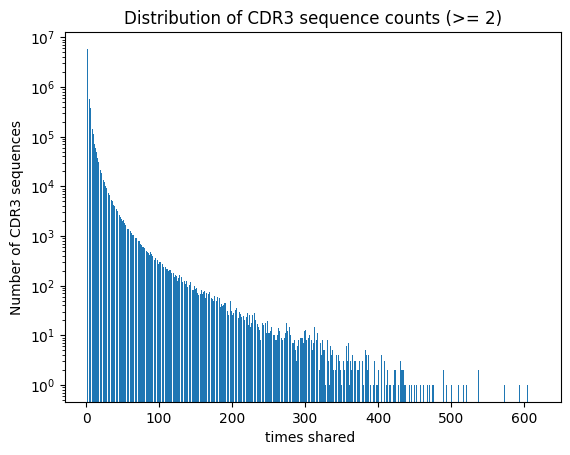

In [16]:
# Count the occurrences of each count value
count_values = tcr_df['count'].value_counts()

# Create a bar plot with labels on the x-axis
plt.bar(count_values.index, count_values.values)
plt.xlabel('times shared ')
plt.ylabel('Number of CDR3 sequences')
plt.title('Distribution of CDR3 sequence counts (>= 2)')

# Add labels to each bar with count values
# for i, v in enumerate(count_values.values):
#   plt.text(i, v + 0.1, str(v), ha='center', va='bottom', fontsize=12)
# Set the y-axis to log scale
plt.yscale('log')
plt.show()

In [36]:
def get_count_threshold(df, unique_value_count):
    """
    This function calculates the count threshold to keep the top tcrs by count.

    Args:
        df (pandas.DataFrame): The dataframe containing tcr and count columns.
        unique_value_count (int): The desired number of unique tcr values to keep in the pruned dataframe.

    Returns:
        float: The count threshold for pruning.
    """
    # Sort the dataframe by count in descending order
    sorted_df = df.sort_values(by="count", ascending=False)

    # Get the count threshold by taking the value at the desired unique_value_count index
    count_threshold = sorted_df.iloc[unique_value_count - 1]['count']

    return count_threshold

# Example usage:
# Assuming tcr_df is your dataframe
unique_value_count = 200000
count_threshold = get_count_threshold(tcr_df.copy(), unique_value_count)
print(f"Count threshold: {count_threshold}")

Count threshold: 24


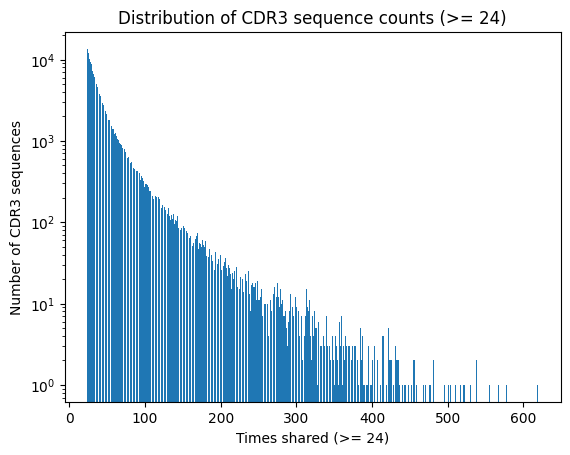

In [37]:
# Filter dataframe for counts greater than or equal to the threshold
tcr_df = tcr_df[tcr_df['count'] >= count_threshold]

# Count the occurrences of each count value in the filtered dataframe
count_values = tcr_df['count'].value_counts()

# Create a bar plot with labels on the x-axis
plt.bar(count_values.index, count_values.values)
plt.xlabel('Times shared (>= ' + str(count_threshold) + ')')
plt.ylabel('Number of CDR3 sequences')
plt.title('Distribution of CDR3 sequence counts (>= ' + str(count_threshold) + ')')

# Set the y-axis to log scale
plt.yscale('log')
plt.show()

tcr_df.to_csv("data/tcr_threshold.csv")

In [38]:
importlib.reload(f)
# We want a list of where every sequence is found [seq1, file_id] ! This same sequence can appear multiple file_ids
tcr_list_samples = f.obtain_sample_name_opt(tcr_df,list_files)
tcr_list_samples

Processing P00030 completed in 1.01 seconds. Progress: 0.15%
Processing P00061 completed in 1.00 seconds. Progress: 0.30%
Processing P00127 completed in 1.06 seconds. Progress: 0.45%
Processing P00033 completed in 1.07 seconds. Progress: 0.60%
Processing P00175 completed in 1.14 seconds. Progress: 0.75%
Processing P00078 completed in 0.81 seconds. Progress: 0.90%
Processing P00173 completed in 0.94 seconds. Progress: 1.05%
Processing P00069 completed in 0.81 seconds. Progress: 1.20%
Processing P00093 completed in 1.72 seconds. Progress: 1.35%
Processing P00092 completed in 1.27 seconds. Progress: 1.50%
Processing P00121 completed in 0.76 seconds. Progress: 1.65%
Processing P00024 completed in 0.86 seconds. Progress: 1.80%
Processing P00042 completed in 0.82 seconds. Progress: 1.95%
Processing P00167 completed in 1.17 seconds. Progress: 2.10%
Processing P00160 completed in 1.25 seconds. Progress: 2.25%
Processing P00161 completed in 1.11 seconds. Progress: 2.40%
Processing P00040 comple

[                       combined file_id
 6       TCRBV05-05CASSLQGSYEQYF  P00030
 60      TCRBV05-05CASSLRGQETQYF  P00030
 140      TCRBV05-05CASSLLGYEQYF  P00030
 170      TCRBV05-05CASSLVGYEQYF  P00030
 282       TCRBV05-05CASSLSYEQYF  P00030
 ...                         ...     ...
 230867      TCRBV06CASSSGNTEAFF  P00030
 230884       TCRBV03CASSRNTEAFF  P00030
 230922      TCRBV03CASSQEGTEAFF  P00030
 230924      TCRBV06CASSYKNTEAFF  P00030
 230937       TCRBV06CASSTNTEAFF  P00030
 
 [14348 rows x 2 columns],
                         combined file_id
 23      TCRBV05-05CASSPGTGGYEQYF  P00061
 58       TCRBV05-05CASSLGGTDTQYF  P00061
 100      TCRBV05-05CASSLGGNSPLHF  P00061
 111        TCRBV05-05CASSLGTEAFF  P00061
 125      TCRBV05-05CASSLGGTDTQYF  P00061
 ...                          ...     ...
 279274     TCRBV12CASSLTGAGNTIYF  P00061
 279285     TCRBV20CSASRTSGTYEQYF  P00061
 279292        TCRBV12CASRLGTEAFF  P00061
 279298       TCRBV03CASSPHTDTQYF  P00061
 279304      TCRB

In [30]:
tcr_list_samples

[                      combined file_id
 2851     TCRBV20-01CSARVGETQYF  P00030
 3283      TCRBV20-01CSARQETQYF  P00030
 3496     TCRBV20-01CSARDSYEQYF  P00030
 5200    TCRBV05-01CASSLGADTQYF  P00030
 6934     TCRBV20-01CSARVGETQYF  P00030
 ...                        ...     ...
 229660     TCRBV03CASSQGGTEAFF  P00030
 229968      TCRBV12CASSLGDTQYF  P00030
 230029      TCRBV03CASSQGETQYF  P00030
 230609     TCRBV03CASSQGGTEAFF  P00030
 230866    TCRBV12CASSLGGNTEAFF  P00030
 
 [412 rows x 2 columns],
                        combined file_id
 3814      TCRBV20-01CSARGGYEQYF  P00061
 5172      TCRBV05-06CASSLGYEQYF  P00061
 6739      TCRBV07-02CASSPSYEQYF  P00061
 6883       TCRBV20-01CSARQETQYF  P00061
 7226    TCRBV27-01CASSLGQGYEQYF  P00061
 ...                         ...     ...
 277701       TCRBV03CASSQAYEQYF  P00061
 278347      TCRBV20CSARDRDTEAFF  P00061
 278814    TCRBV12CASSLGGSSYEQYF  P00061
 278834      TCRBV03CASSQGNTEAFF  P00061
 279216     TCRBV12CASSLGPNTEAFF  P00061
 

In [39]:
# Now we join all cdr3 sequences 
cdr3_files = pd.concat(tcr_list_samples, ignore_index=True)

# Group by 'cdr3' column and aggregate 'sample_id' column
cdr3_files = cdr3_files.groupby('combined')['file_id'].apply(lambda x: ','.join(x)).reset_index()

cdr3_files.to_csv('data/v_gene_cdr3_files.csv',index=False)
cdr3_files

,combined,file_id
0,TCRBV02-01CAFFKQKTAYEQYF,"P00030,P00078,P00173,P00160,P00036,P00163,P000..."
1,TCRBV02-01CAIFFKQKTAYEQYF,"P00061,P00175,P00027,P00176,P00012,P00074,P000..."
2,TCRBV02-01CAIFKQKTAYEQYF,"P00175,P00198,P00198,P00058,P00044,P00176,P001..."
3,TCRBV02-01CARGTGNTEAFF,"P00080,P00146,P00106,P00138,P00079,P00122,P000..."
4,TCRBV02-01CASAGNTEAFF,"P00030,P00092,P00092,P00178,P00044,P00067,P001..."
...,...,...
206648,TCRBV30-01CVFFKQKTAYEQYF,"P00175,P00173,P00093,P00092,P00024,P00167,P001..."
206649,TCRBV30-01CVFKQKTAYEQYF,"P00198,P00015,P00146,P00019,P00028,P00023,P001..."
206650,TCRBV30-01FFFKQKTAYEQYF,"P00175,P00069,P00092,P00121,P00075,P00048,P001..."
206651,TCRBV30-01FFKQKTAYEQYF,"P00033,P00092,P00092,P00075,P00080,P00198,P001..."


In [40]:
# Split file_id into individual IDs and create columns
cdr3_files['file_id'] = cdr3_files['file_id'].apply(lambda x: x.split(','))
file_ids = sorted(set([id for sublist in cdr3_files['file_id'] for id in sublist]))
for file_id in file_ids:
    cdr3_files[file_id] = cdr3_files['file_id'].apply(lambda x: file_id in x)

# Rearrange columns
cdr3_files = cdr3_files[['combined'] + file_ids]

cdr3_files

/tmp/ipykernel_3566/1063566084.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdr3_files[file_id] = cdr3_files['file_id'].apply(lambda x: file_id in x)
/tmp/ipykernel_3566/1063566084.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdr3_files[file_id] = cdr3_files['file_id'].apply(lambda x: file_id in x)
/tmp/ipykernel_3566/1063566084.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

,combined,P00001,P00002,P00003,P00004,P00005,P00006,P00007,P00008,P00009,P00010,P00011,P00012,P00013,P00014,P00015,P00016,P00017,P00018,P00019,P00020,P00021,P00022,P00023,P00024,P00025,P00026,P00027,P00028,P00029,P00030,P00031,P00032,P00033,P00034,P00035,P00036,P00037,P00038,P00039,P00040,P00041,P00042,P00043,P00044,P00045,P00046,P00047,P00048,P00049,P00050,P00051,P00052,P00053,P00054,P00055,P00056,P00057,P00058,P00059,P00060,P00061,P00062,P00063,P00064,P00065,P00066,P00067,P00068,P00069,P00070,P00071,P00072,P00073,P00074,P00075,P00076,P00077,P00078,P00079,P00080,P00081,P00083,P00084,P00085,P00086,P00087,P00088,P00089,P00090,P00091,P00092,P00093,P00094,P00095,P00096,P00097,P00098,P00099,P00100,P00101,P00102,P00103,P00104,P00105,P00106,P00107,P00108,P00109,P00110,P00111,P00112,P00113,P00114,P00115,P00116,P00117,P00118,P00119,P00120,P00121,P00122,P00123,P00124,P00125,P00126,P00127,P00128,P00129,P00130,P00131,P00132,P00133,P00134,P00135,P00136,P00137,P00138,P00139,P00140,P00141,P00142,P00143,P00144,P00145,P00146,P00147,P00148,P00149,P00150,P00151,P00152,P00153,P00154,P00155,P00156,P00157,P00158,P00159,P00160,P00161,P00162,P00163,P00164,P00165,P00166,P00167,P00168,P00169,P00170,P00171,P00172,P00173,P00174,P00175,P00176,P00177,P00178,P00179,P00180,P00181,P00182,P00183,P00184,P00185,P00186,P00187,P00188,P00189,P00190,P00191,P00192,P00193,P00194,P00195,P00196,P00197,P00198,P00199,P00200,P00201,P00202,P00203,P00204,P00205,P00206,P00207,P00208,P00209,P00210,P00211,P00212,P00213,P00214,P00215,P00216,P00217,P00218,P00219,P00220,P00221,P00222,P00223,P00224,P00225,P00226,P00227,P00228,P00229,P00230,P00231,P00232,P00233,P00234,P00235,P00236,P00237,P00238,P00239,P00240,P00241,P00242,P00243,P00244,P00245,P00246,P00247,P00248,P00249,P00250,P00251,P00252,P00253,P00254,P00255,P00256,P00257,P00258,P00259,P00260,P00261,P00262,P00263,P00264,P00265,P00266,P00267,P00268,P00269,P00270,P00271,P00272,P00273,P00274,P00275,P00276,P00277,P00278,P00279,P00280,P00281,P00282,P00283,P00284,P00285,P00286,P00287,P00288,P00289,P00290,P00291,P00292,P00293,P00294,P00295,P00296,P00297,P00298,P00299,P00300,P00301,P00302,P00303,P00304,P00305,P00306,P00307,P00308,P00309,P00310,P00311,P00312,P00313,P00314,P00315,P00316,P00317,P00318,P00319,P00320,P00321,P00322,P00323,P00324,P00325,P00326,P00327,P00328,P00329,P00330,P00331,P00332,P00333,P00334,P00335,P00336,P00337,P00338,P00339,P00340,P00341,P00342,P00343,P00344,P00345,P00346,P00347,P00348,P00349,P00350,P00351,P00352,P00353,P00354,P00355,P00356,P00357,P00358,P00359,P00360,P00361,P00362,P00363,P00364,P00365,P00366,P00367,P00368,P00369,P00370,P00371,P00372,P00373,P00374,P00375,P00376,P00377,P00378,P00379,P00380,P00381,P00382,P00383,P00384,P00385,P00386,P00387,P00388,P00389,P00390,P00391,P00392,P00393,P00394,P00395,P00396,P00397,P00398,P00399,P00400,P00401,P00402,P00403,P00404,P00405,P00406,P00407,P00408,P00409,P00410,P00411,P00412,P00413,P00414,P00415,P00416,P00417,P00418,P00419,P00420,P00421,P00422,P00423,P00424,P00425,P00426,P00427,P00428,P00429,P00430,P00431,P00432,P00433,P00434,P00435,P00436,P00437,P00438,P00439,P00440,P00441,P00442,P00443,P00444,P00445,P00446,P00447,P00448,P00449,P00450,P00451,P00452,P00453,P00454,P00455,P00456,P00457,P00458,P00459,P00460,P00461,P00462,P00463,P00464,P00465,P00466,P00467,P00468,P00469,P00470,P00471,P00472,P00473,P00474,P00475,P00476,P00477,P00478,P00479,P00480,P00481,P00482,P00483,P00484,P00485,P00486,P00487,P00488,P00489,P00490,P00491,P00492,P00493,P00494,P00495,P00496,P00497,P00498,P00499,P00500,P00501,P00502,P00503,P00504,P00505,P00506,P00507,P00508,P00509,P00510,P00511,P00512,P00513,P00514,P00515,P00516,P00517,P00518,P00519,P00520,P00521,P00522,P00523,P00524,P00525,P00526,P00527,P00528,P00529,P00530,P00531,P00532,P00533,P00534,P00535,P00536,P00537,P00538,P00539,P00540,P00541,P00542,P00543,P00544,P00545,P00546,P00547,P00548,P00549,P00550,P00551,P00552,P00553,P00554,P00555,P00556,P00557,P00558,P00559,P00560,P00561,P00562,P00563,P00564,P00565,P00566,P00567,P00568,P00569,P00570,P00571,

In [41]:
cdr3_files.to_csv("v_gene_tcr_filelist.csv")